# Filtering and QAQC

This notebook is intended largely as a quality check for freshly minted hyperclouds. It is also a good opportunity to smooth spectra to reduce noise etc. before generating data products or interpretations. Finally, hull corrected clouds can be generated as a final spectral cleaning step. 

In [1]:
import os
import numpy as np
import hylite
import hylite.io as io
from hylite.correct import get_hull_corrected

### Load and plot hypercloud and spectra (QAQC)

In [2]:
cloud_path = '/Users/thiele67/Documents/Data/CA/hypercloud/CA_0082__3_3m00_4m00_radiance_non_uni_cc.ply'
cloud = io.loadCloudPLY(cloud_path)

In [16]:
export_directory = '/Users/thiele67/Documents/Data/CA/hypercloud/'

# settings for preview plots
n = 1 # index of camera to use for plot.
s = 2 # size of points (in pixels; must be integer)

# smoothing settings
method = 'median' # options are 'median' or 'savgol'
window = 3 # the size of the smoothing window (in bands). Must be an integer.  

# hull correction settings
hull_correct = True # set to True to calculate and export hull corrected cloud also
band_range= (2000.0,-1) # bands to include in the hull corrected cloud. (0,-1) includes all bands.

Generate preview images (QAQC: inspect these carefully! 🧐 )

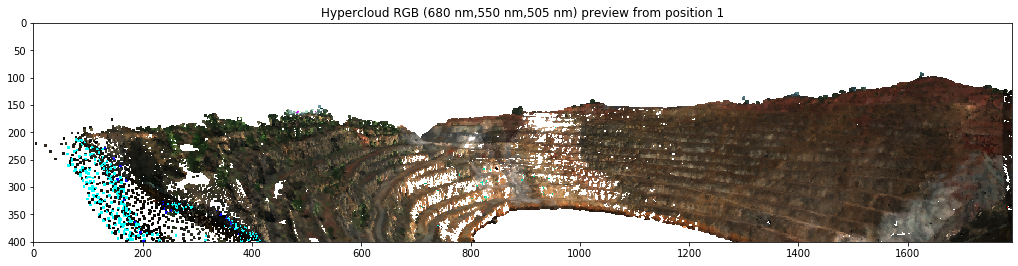

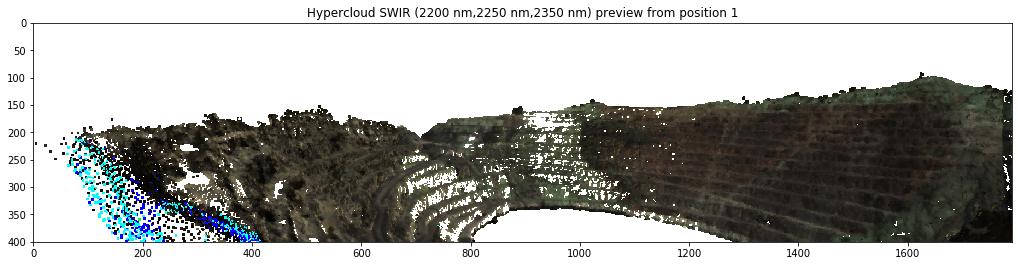

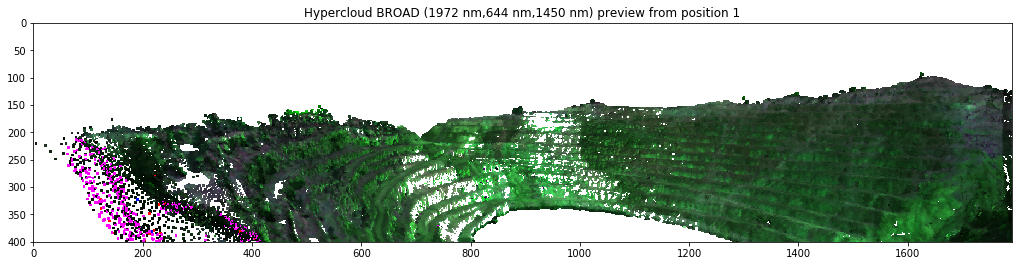

In [4]:
# generate preview
cam = cloud.header.get_camera(n)

fig,ax = cloud.quick_plot(cam, hylite.RGB, s=s, fill_holes=True)
ax.set_title("Hypercloud RGB (%d nm,%d nm,%d nm) preview from position %d" % (*hylite.RGB, n))
fig.show()

fig,ax = cloud.quick_plot(cam, hylite.SWIR, s=s, fill_holes=True)
ax.set_title("Hypercloud SWIR (%d nm,%d nm,%d nm) preview from position %d" % (*hylite.SWIR, n))
fig.show()

fig,ax = cloud.quick_plot(cam, hylite.BROAD, s=s, fill_holes=True)
ax.set_title("Hypercloud BROAD (%d nm,%d nm,%d nm) preview from position %d" % (*hylite.BROAD, n))
fig.show()

Generate preview spectra (QAQC: inspect these carefully! 🧐 )

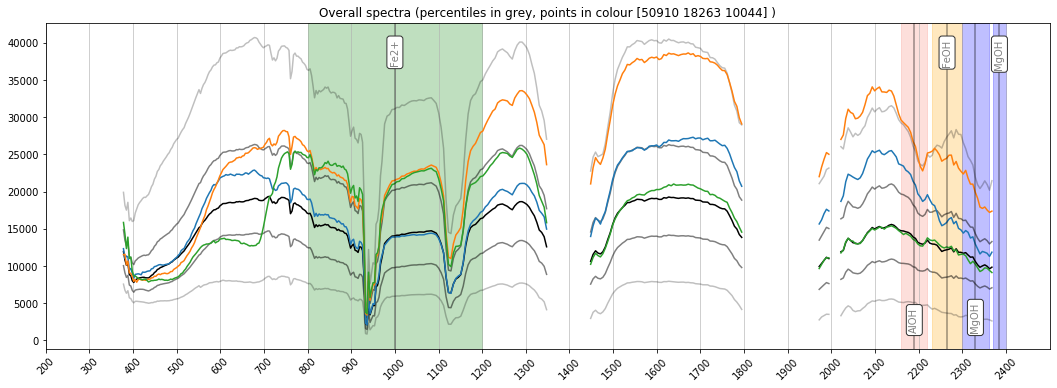

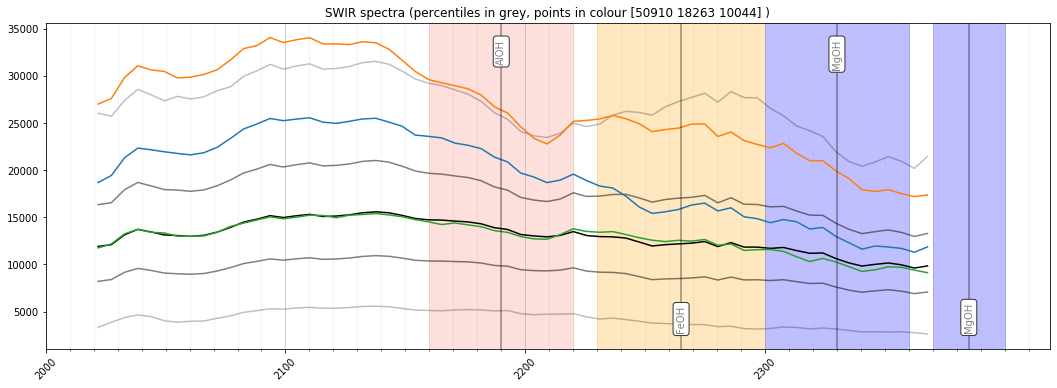

In [5]:
# choose some random points
np.random.seed(42)
idx = (np.random.rand(3) * cloud.point_count()).astype(np.uint16)
fig,ax = cloud.plot_spectra( indices = idx)
ax.set_title("Overall spectra (percentiles in grey, points in colour %s )" % idx)
fig.show()

if (np.min( cloud.get_wavelengths() ) < 2000.0 and np.max( cloud.get_wavelengths()) > 2400.0 ):
    fig,ax = cloud.plot_spectra( band_range = (2000.0, 2400.0), indices=idx )
    ax.set_title("SWIR spectra (percentiles in grey, points in colour %s )" % idx)
    fig.show()

### Smooth spectra

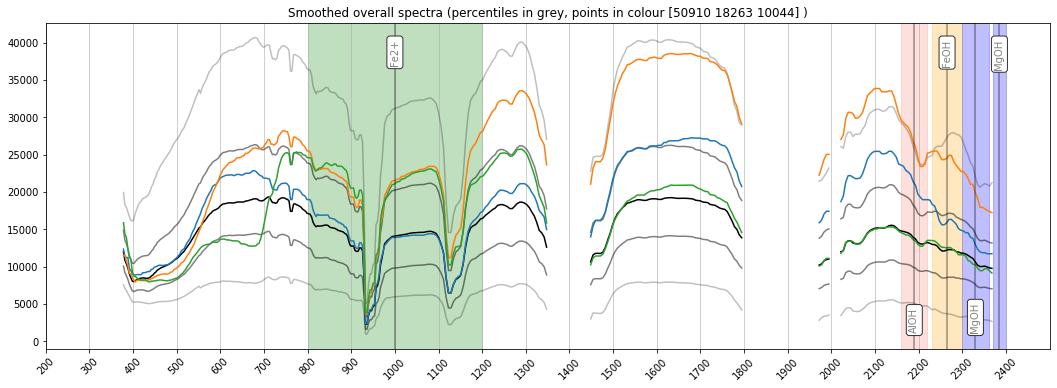

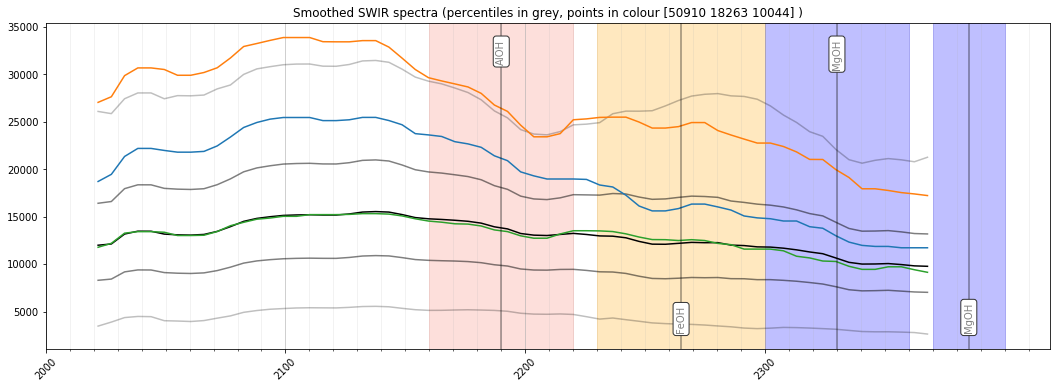

In [6]:
if method == None or method == '':
    print("Not applying smoothing to spectra")
else:
    if 'sav' in method.lower():
        cloud.smooth_savgol( window ) # smooth using savgol filter
    elif 'med' in method.lower():
        cloud.smooth_median( window ) # smooth using median filter
    else:
        assert False, "'%s' is an unknown smoothing method" % method

    fig,ax = cloud.plot_spectra( indices = idx)
    ax.set_title("Smoothed overall spectra (percentiles in grey, points in colour %s )" % idx)
    fig.show()

    if (np.min( cloud.get_wavelengths() ) < 2000.0 and np.max( cloud.get_wavelengths()) > 2400.0 ):
        fig,ax = cloud.plot_spectra( band_range = (2000.0, 2400.0), indices=idx )
        ax.set_title("Smoothed SWIR spectra (percentiles in grey, points in colour %s )" % idx)
        fig.show()

### Hull correct

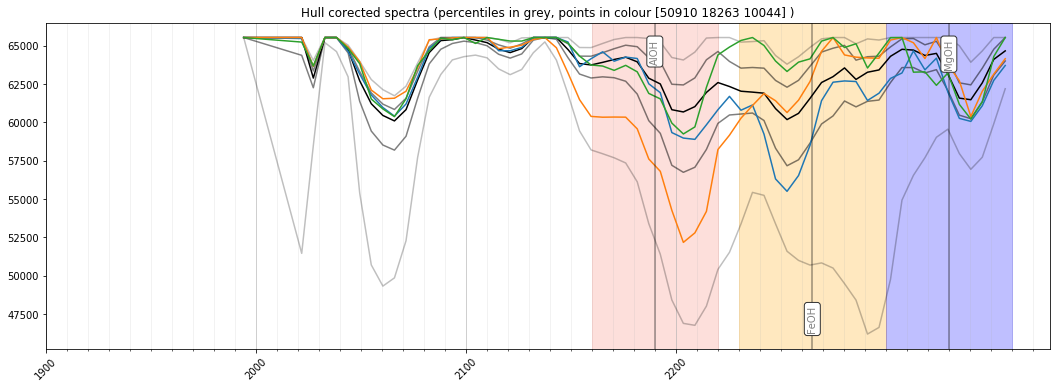

In [9]:
# delete bad bands (these interfere with the correction)
cloud = cloud.export_bands( cloud.header.get_bbl() ) 

# apply hull correction
if hull_correct:
    cloud_hc = get_hull_corrected( cloud, band_range=band_range ) # apply hull correction. This can take time....
    
    fig,ax = cloud_hc.plot_spectra( band_range=band_range, indices = idx)
    ax.set_title("Hull corected spectra (percentiles in grey, points in colour %s )" % idx)
    fig.show()

### Export filtered cloud

In [17]:
if not (method == '' or method == None):
    name = os.path.splitext(os.path.basename( cloud_path ))[0] + '_smth.ply'
    cloud.compress()
    io.saveCloudPLY( os.path.join(export_directory, name), cloud)

if hull_correct:
    name = os.path.splitext(os.path.basename( cloud_path ))[0] + '_hc.ply'
    cloud_hc.compress()
    io.saveCloudPLY( os.path.join(export_directory, name), cloud_hc)